<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/AA_Iron_Ore_Froth_Flotation_Quality_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Quality Prediction of Iron Ore Mining Flotation Process**

##**1. Problem Definition:**

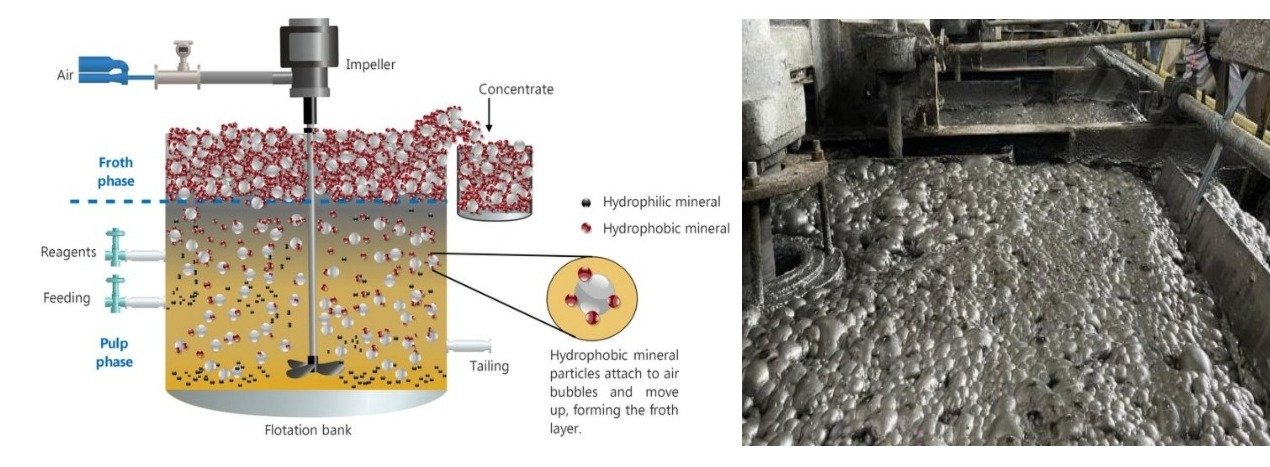

**Gangue concentrate predict in the reverse cationic flotation**


Mined ores are mostly mixtures of extractable minerals and nonvaluable material (gangue). Mineral processing (e.g. ore dressing, ore beneficiation) follows mining and prepares the ore for extraction of the valuable metal. A principal step in mineral processing is physical separation of the particles of valuable minerals from the gangue, to produce an enriched portion (concentrate) containing most of the valuable minerals, and a discard (tailing) containing predominantly the gangue.

A separation of minerals by exploiting difference of surface properties (hydrophobicity) is called flotation. **The reverse cationic flotation** is commonly used to separate iron from silica. By adjusting the 'chemistry' of the pulp by adding various chemical reagents, iron minerals remain in the water and create sediment with a high concentration of iron (valuable minerals). At the same time, silica particles (gangue) attach to air bubbles and float to the surface.

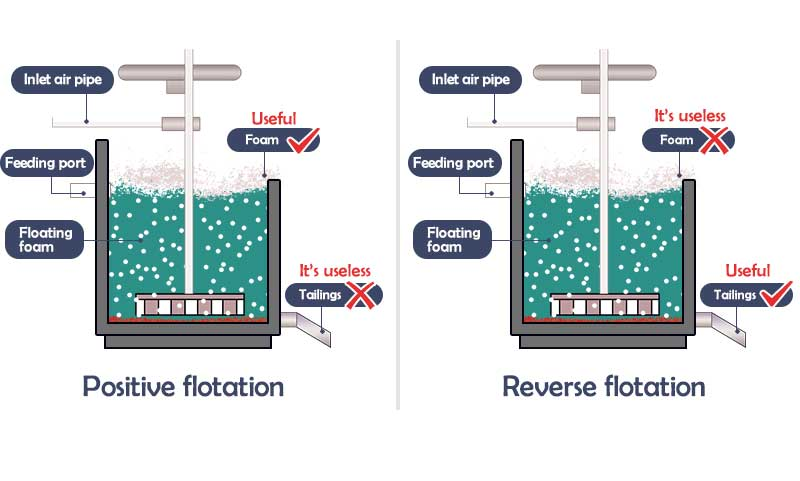

Flotation concentrate is periodically sampled to determine its purity (i.e., *%valuable*, *%gangue*). Higher *%gangue* in the concentrate is undesirable as it indicates that most valuable minerals had gone into the tailing. Purity measurement is usually done in a lab and can take some time before process engineers can make any adjustments based on the results. A timely investigation of concentrate purity is, therefore, a fundamental aspect for the control and optimization of the flotation process.

This project explores the application of machine learning to forecast gangue (*%silica*) in the flotation concentrate. The forecast will help process engineers assess purity of flotation concentrate and take corrective actions in advance. More specifically, the goal is to tackle the following tasks:
- **To predict the last column (dependent variable), which is the % of silica in the iron ore concentrate.**

##**2. Data Understanding:**

###**2.1. Data Definitions**:

- **Date**: Data collection time.
- **% Iron Feed**: Feed grade of iron-containing ore.
- **% Silica Feed**: Feed grade of silica-containing ore.
- **Starch Flow**: Depressant chemical for Iron(Fe) containing ore measured in m³/h.
- **Amina Flow**: Collector chemical for Silica containing ore measured in m³/h.
- **Ore Pulp Flow**: The amount of pulp flow fed to the flotation columns as the product of the previous process step measured in t/h.
- **Ore Pulp pH**: pH is measured in pH scale.
- **Ore Pulp Density**: The solid percent of ore fed density ranges in kg/cm³
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Air Flow**: Air Flows that goes into the flotation cell measured in Nm³/h.
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Level**: Froth level in the flotation cell measured in mm.
- **% Iron Concentrate**: Concentrate grade of iron-containing ore in percentage.
- **% Silica Concentrate**: Concentrate grade of silica-containing ore in percentage

###**2.2. Inspection of the data:**

- The first column shows time and date range (from march of 2017 until september of 2017). 
- Some columns were sampled every 20 second. Others were sampled on a hourly base.
- The second and third columns are quality measures of the iron ore pulp right before it is fed into the flotation plant. 
- From Column 4 until column 8 are the most important variables that impact in the ore quality in the end of the process. 
- From column 9 until column 22, we can see process data (level and air flow inside the flotation columns, which also impact in ore quality). 
- The last two columns are the final iron ore pulp quality measurement from the lab. 

##**3. Data Collection:**

###**3.1. Import Libraries and Modules:**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import (LinearRegression, 
                                 LogisticRegression, SGDRegressor)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

###**3.2. Import Dataset:**

In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/Flotation/

flotation = pd.read_csv('Flotation_Plant.csv', decimal = ",")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


##**4. Data Exploration & Preparation:**

###**4.1. Check the dataset**

In [3]:
flotation.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,...,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,...,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
3,2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,...,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
4,2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,...,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31


In [4]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   date                          737453 non-null  object 
 1   % Iron Feed                   737453 non-null  float64
 2   % Silica Feed                 737453 non-null  float64
 3   Starch Flow                   737453 non-null  float64
 4   Amina Flow                    737453 non-null  float64
 5   Ore Pulp Flow                 737453 non-null  float64
 6   Ore Pulp pH                   737453 non-null  float64
 7   Ore Pulp Density              737453 non-null  float64
 8   Flotation Column 01 Air Flow  737453 non-null  float64
 9   Flotation Column 02 Air Flow  737453 non-null  float64
 10  Flotation Column 03 Air Flow  737453 non-null  float64
 11  Flotation Column 04 Air Flow  737453 non-null  float64
 12  Flotation Column 05 Air Flow  737453 non-nul

In [5]:
# Rename column names
old_columns = ['date', '% Iron Feed', '% Silica Feed', 'Starch.Flow',
               'Amina.Flow', 'Ore.Pulp.Flow', 'Ore.Pulp.pH', 'Ore.Pulp.Density', 
               'Flotation.Column.01.Air.Flow', 'Flotation.Column.02.Air.Flow', 
               'Flotation.Column.03.Air.Flow', 'Flotation.Column.04.Air.Flow', 
               'Flotation.Column.05.Air.Flow', 'Flotation.Column.06.Air.Flow', 
               'Flotation.Column.07.Air.Flow', 
               'Flotation.Column.01.Level', 'Flotation.Column.02.Level', 
               'Flotation.Column.03.Level', 'Flotation.Column.04.Level', 
               'Flotation.Column.05.Level', 'Flotation.Column.06.Level', 
               'Flotation.Column.07.Level',
               '% Iron Concentrate', '% Silica Concentrate']
new_columns = ["date", "iron_feed", "silica_feed", "starch_flow",
               "amina_flow", "pulp_flow", "pulp_pH", "pulp_density",
               "air_flow_col1", "air_flow_col2", "air_flow_col3",
               "air_flow_col4", "air_flow_col5", "air_flow_col6", "air_flow_col7", 
               "level_col1", "level_col2", "level_col3", "level_col4", "level_col5", 
               "level_col6", "level_col7",
               "iron_concentrate", "silica_concentrate"]

flotation = flotation.rename(columns=dict(zip(old_columns, new_columns)))

In [6]:
# Drop the unnecessary column "date"
flotation.drop('date', axis=1, inplace=True)

###**4.2. Relations between variables**

In [7]:
flotation.describe().T

,count,mean,std,min,25%,50%,75%,max
iron_feed,737453.0,56.294739,5.157744,42.740000,52.670000,56.080000,59.720000,65.78000
silica_feed,737453.0,14.651716,6.807439,1.310000,8.940000,13.850000,19.600000,33.40000
Starch Flow,737453.0,2869.140569,1215.203734,0.002026,2076.320000,3018.430000,3727.730000,6300.23000
Amina Flow,737453.0,488.144697,91.230534,241.669000,431.796000,504.393000,553.257000,739.53800
Ore Pulp Flow,737453.0,397.578372,9.699785,376.249000,394.264000,399.249000,402.968000,418.64100
Ore Pulp pH,737453.0,9.767639,0.387007,8.753340,9.527360,9.798100,10.038000,10.80810
Ore Pulp Density,737453.0,1.680380,0.069249,1.519820,1.647310,1.697600,1.728330,1.85325
Flotation Column 01 Air Flow,737453.0,280.151856,29.621288,175.510000,250.281000,299.344000,300.149000,373.87100
Flotation Column 02 Air Flow,737453.0,277.159965,30.149357,175.156000,250.457000,296.223000,300.690000,375.99200
Flotation Column 03 Air Flow,737453.0,281.082397,28.558268,176.469000,250.855000,298.696000,300.382000,364.34600


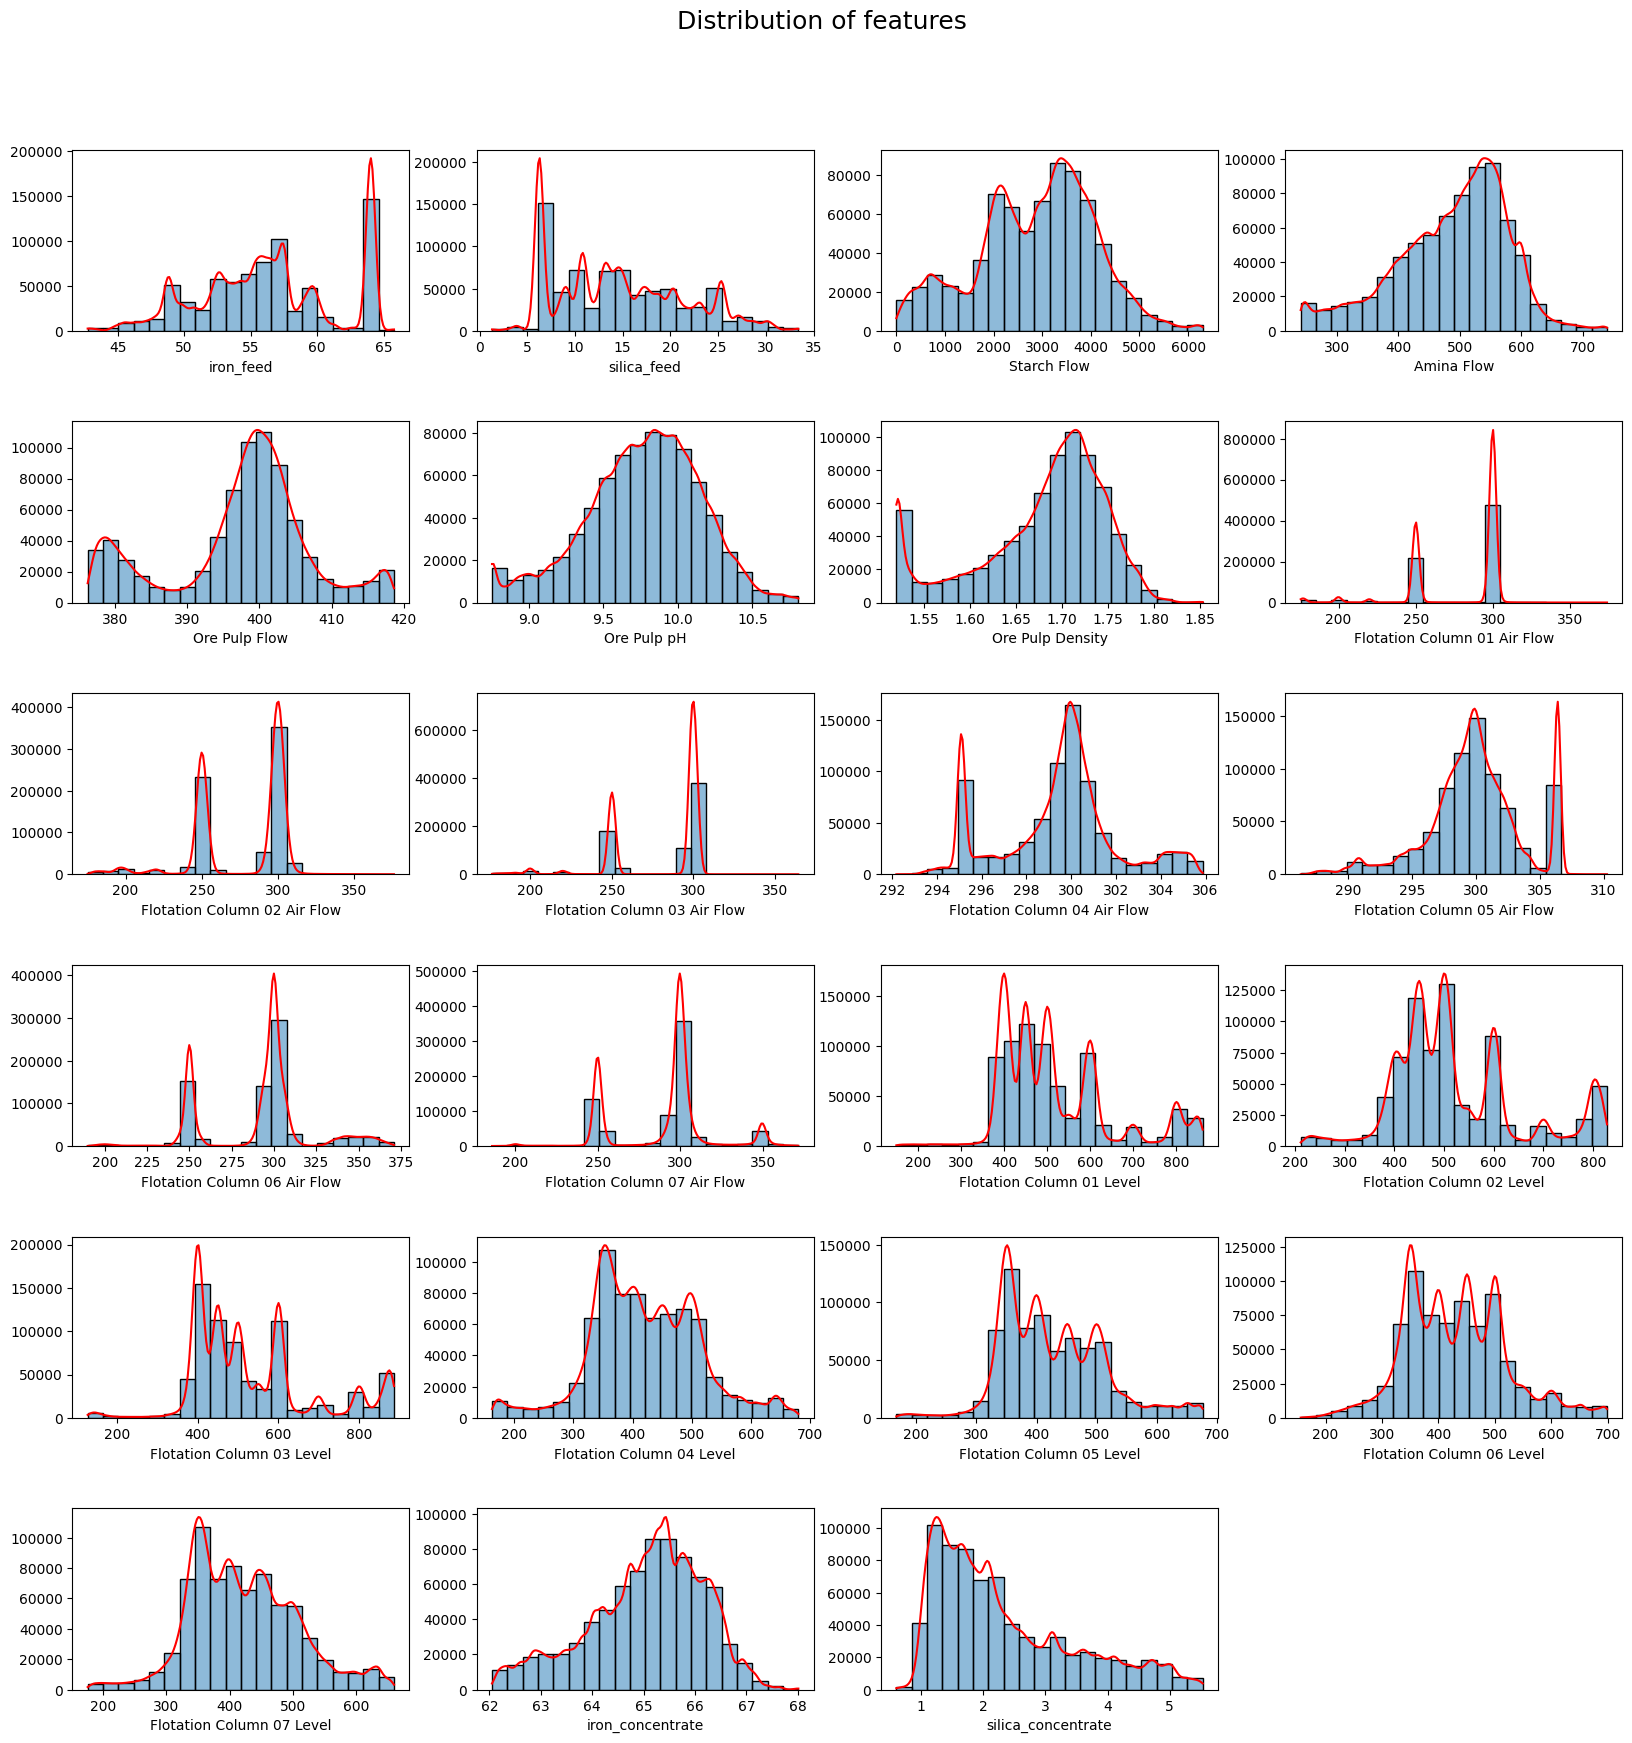

In [8]:
features = flotation.columns
plt.figure(figsize= (20,20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Distribution of features", fontsize=18, y=0.95)
for i, feature in enumerate(features):
 k = i + 1
 plt.subplot(6,4,int(k))
 sns.histplot(data = flotation, x= feature,kde=True, bins = 20).lines[0].set_color('red')
 plt.xlabel(feature)
 plt.ylabel("")
plt.show()

In [12]:
# Calculate the correlation matrix
correlation_matrix = flotation.corr()
correlation_matrix

,iron_feed,silica_feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,iron_concentrate,silica_concentrate
iron_feed,1.000000,-0.971833,0.027981,-0.088148,0.160705,0.007451,-0.125518,-0.062379,-0.169430,-0.062207,...,-0.016356,0.029499,0.020839,0.015191,0.016108,0.023288,0.003694,0.025723,0.055424,-0.077052
silica_feed,-0.971833,1.000000,-0.016073,0.078735,-0.150788,0.008014,0.104497,0.091757,0.182573,0.084197,...,0.045300,-0.038291,-0.036968,-0.022675,-0.034050,-0.043753,-0.019502,-0.046413,-0.044168,0.072724
Starch Flow,0.027981,-0.016073,1.000000,0.254748,0.042703,0.263020,0.226004,0.191131,0.186585,0.183288,...,0.194786,-0.294380,-0.278422,-0.301757,-0.012612,-0.055528,-0.071722,-0.038193,0.069657,-0.066394
Amina Flow,-0.088148,0.078735,0.254748,1.000000,0.212252,0.123690,0.655788,0.111321,0.122911,0.101957,...,0.079558,-0.268536,-0.234454,-0.286968,-0.180301,-0.211712,-0.197758,-0.168050,-0.110148,0.156701
Ore Pulp Flow,0.160705,-0.150788,0.042703,0.212252,1.000000,0.118376,0.012279,-0.137866,-0.118549,-0.140761,...,-0.140914,-0.008579,-0.008049,-0.054351,-0.009784,0.002260,-0.016661,0.016585,0.083120,0.008222
Ore Pulp pH,0.007451,0.008014,0.263020,0.123690,0.118376,1.000000,0.115189,0.163073,0.144935,0.193372,...,0.174684,-0.165739,-0.153557,-0.140070,0.046371,0.013041,-0.075034,0.019021,0.192992,-0.147739
Ore Pulp Density,-0.125518,0.104497,0.226004,0.655788,0.012279,0.115189,1.000000,-0.005142,0.025794,-0.031673,...,-0.052294,-0.111608,-0.093024,-0.149584,-0.087761,-0.140881,-0.099817,-0.086067,0.015580,0.046984
Flotation Column 01 Air Flow,-0.062379,0.091757,0.191131,0.111321,-0.137866,0.163073,-0.005142,1.000000,0.848277,0.954528,...,0.646768,-0.441573,-0.425758,-0.371791,-0.061940,-0.091386,-0.118992,-0.110726,0.098599,-0.219158
Flotation Column 02 Air Flow,-0.169430,0.182573,0.186585,0.122911,-0.118549,0.144935,0.025794,0.848277,1.000000,0.860438,...,0.578578,-0.432033,-0.422855,-0.365535,-0.074312,-0.110512,-0.117619,-0.112403,0.058744,-0.167398
Flotation Column 03 Air Flow,-0.062207,0.084197,0.183288,0.101957,-0.140761,0.193372,-0.031673,0.954528,0.860438,1.000000,...,0.649435,-0.440823,-0.420932,-0.364773,-0.046685,-0.063693,-0.100419,-0.085294,0.100136,-0.218891


###**4.3. Check Missing Values**

In [9]:
df_datatype = pd.concat([flotation.dtypes, flotation.nunique(),
                         round(flotation.nunique()*100/len(flotation), 2),
                         flotation.isnull().sum(),
                         round(flotation.isnull().sum()*100/len(flotation),2)],
                        axis=1)

df_datatype.columns = ['data type',
                       'No. of categories',
                       'No. of categories %',
                       'missing values',
                       'missing values %']

df_datatype.sort_values(by='missing values %',
                        ascending=False, inplace=True)
df_datatype

,data type,No. of categories,No. of categories %,missing values,missing values %
iron_feed,float64,278,0.04,0,0.0
Flotation Column 06 Air Flow,float64,90548,12.28,0,0.0
iron_concentrate,float64,38696,5.25,0,0.0
Flotation Column 07 Level,float64,295667,40.09,0,0.0
Flotation Column 06 Level,float64,301502,40.88,0,0.0
Flotation Column 05 Level,float64,276051,37.43,0,0.0
Flotation Column 04 Level,float64,309264,41.94,0,0.0
Flotation Column 03 Level,float64,322315,43.71,0,0.0
Flotation Column 02 Level,float64,331189,44.91,0,0.0
Flotation Column 01 Level,float64,299573,40.62,0,0.0


- No missing values across the dataframe

###**4.3. Check Duplicated Values**

In [ ]:
#check duplicated rows
duplicate_rows = flotation[flotation.duplicated()]
duplicate_rows.shape

In [ ]:
#drop duplicated rows
flotation = flotation.drop_duplicates()
flotation.shape